# Lecture 4: Simple Algorithms for Stock Return Prediction

## Introduction

In this notebook, we will implement and compare **four key machine learning models** for stock return prediction:

1. **Linear Regression (OLS)** – the baseline linear model.
2. **Regularized Regression (Lasso, Ridge, Elastic Net)** – improved generalization in high-dimensional, noisy settings.
3. **Random Forest (RF)** – nonlinear, ensemble method robust to noise.
4. **Gradient Boosting (GBDT, XGBoost, LightGBM)** – sequential ensemble method, industry standard for tabular prediction.

---

### Why Machine Learning for Stock Prediction?
- Stock returns are **noisy** and often weakly predictable.  
- Firm characteristics can be **high-dimensional** and correlated.  
- Machine learning models help capture **nonlinear patterns** and avoid overfitting via regularization and ensembles.

---

### Evaluation Metrics
We will compare models using the following metrics:

- **RMSE (Root Mean Squared Error):** accuracy, penalizes large errors.  
- **MAE (Mean Absolute Error):** average error magnitude, robust to outliers.  
- **Hit Ratio:** percentage of correct up/down predictions.  
- **Fit Time:** computational efficiency of model training.  

> In finance, **out-of-sample performance** is the gold standard — models must be evaluated on unseen data to ensure predictive power.

---

### Notebook Workflow
1. Load and preprocess financial data.  
2. Train models using historical features.  
3. Evaluate models with RMSE, MAE, Hit Ratio, and training time.  
4. Compare results to highlight **strengths and limitations** of each method.  

---


In [1]:
# === Requirements / Imports ===
import os
import wrds
from dotenv import load_dotenv
from typing import Union, Callable, Dict, Any, Optional

# Data handling
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit

from math import sqrt, erf
from scipy.stats import norm

# Timing
import time

# Display settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## Load and preprocessing data
### Download data from WRDS

In [2]:
# === Data Loading from WRDS ===
# This script downloads *only Microsoft (MSFT, PERMNO=10107)* monthly stock data
# from the CRSP Monthly Stock File (msf).
# Key variables:
#   - prc: raw price (may drop/jump due to stock splits, dividends, etc.)
#   - cfacpr: price adjustment factor
#   - adjprc: adjusted price (continuous, suitable for long-term analysis)
#   - ret: monthly return
#   - vol: trading volume
#   - shrout: shares outstanding
#   - me: market equity (market cap = |prc| * shrout)

load_dotenv()
wrds_user = os.getenv("WRDS_USER")

start_time = '1990-01-01'
end_time = '2024-12-31'

# Connect to WRDS
db = wrds.Connection(wrds_username=wrds_user)

PERMNO_LIST = [10107]  # 10107 corresponds to Microsoft (MSFT)

# ---------------------------
# 1. CRSP Monthly Stock Data
# ---------------------------
crsp_msf = db.raw_sql(f"""
    select permno, date, ret, vol, shrout, prc, cfacpr
    from crsp.msf
    where permno in ({",".join(str(x) for x in PERMNO_LIST)}) 
      and date between '{start_time}' and '{end_time}'
""")

# Clean CRSP data and compute derived variables
crsp_msf['date'] = pd.to_datetime(crsp_msf['date'])
crsp_msf['ret'] = pd.to_numeric(crsp_msf['ret'], errors='coerce')
crsp_msf['me'] = crsp_msf['prc'].abs() * crsp_msf['shrout']     # Market equity
crsp_msf['adjprc'] = crsp_msf['prc'] * crsp_msf['cfacpr']       # Adjusted price


def build_features(g):
    g = g.sort_values('date').copy()

    # 2.1 Simple lags / momentum
    g['ret_l1'] = g['ret'].shift(1)
    # 12-1 momentum: cumret over t-12..t-2 * (1+ret_{t-1}) - 1, but we keep standard proxy:
    g['mom_12_1'] = (1.0 + g['ret'].shift(1)).rolling(12).apply(np.prod, raw=True) - 1.0

    # 2.2 Rolling volatility (6m)
    g['vol_6m'] = g['ret'].rolling(6).std()

    # 2.3 Dollar volume proxy and (very) simplified Amihud illiquidity
    # dollar volume ~ |PRC| * SHROUT * VOL?  At monthly freq, we use:
    # Turnover (approx): VOL / SHROUT (both in CRSP units)
    g['turnover'] = (g['vol'] / (g['shrout'] * 1000)).replace([np.inf, -np.inf], np.nan)

    # Dollar volume proxy: |PRC| * VOL (ignoring price sign conventions)
    dollar_vol = g['prc'].abs() * g['vol']
    g['illiq'] = (g['ret'].abs() / (dollar_vol.replace(0, np.nan))).replace([np.inf, -np.inf], np.nan)

    # 2.4 Log price to capture scale
    g['log_prc'] = np.log(g['prc'].abs())

    return g

crsp_msf = crsp_msf.groupby('permno').apply(build_features).reset_index(drop=True)

Loading library list...
Done


In [3]:
crsp_msf.describe()

,permno,date,ret,vol,shrout,prc,cfacpr,me,adjprc,ret_l1,mom_12_1,vol_6m,turnover,illiq,log_prc
count,420.0,420,420.0,420.0,420.0,420.0,420.0,420.0,420.0,419.0,408.000000,415.000000,420.0,420.0,420.0
mean,10107.0,2007-07-15 18:58:17.142857216,0.020465,7217944.680952,6131108.628571,96.353932,8.97381,556567029.874521,811.578544,0.020525,0.263798,0.077324,0.001266,0.0,4.21707
min,10107.0,1990-01-31 00:00:00,-0.343529,99427.0,55676.0,16.15,1.0,5150030.0,16.15,-0.343529,-0.628480,0.015519,0.000457,0.0,2.78192
25%,10107.0,1998-10-22 12:00:00,-0.034439,3106792.0,2487159.0,29.515,1.0,198998468.775,29.515,-0.034468,0.024545,0.049548,0.000912,0.0,3.384898
50%,10107.0,2007-07-15 00:00:00,0.020833,6484690.0,7567653.0,66.375,1.0,280408817.745,117.31,0.020874,0.224723,0.068130,0.001236,0.0,4.195319
75%,10107.0,2016-04-07 06:00:00,0.064293,11054834.0,8402382.0,109.96875,4.0,466250464.955625,431.099992,0.064384,0.459050,0.090547,0.001514,0.0,4.700196
max,10107.0,2024-12-31 00:00:00,0.407781,30441987.0,10880222.0,446.95001,144.0,3322626374.34,15948.0,0.407781,1.400848,0.250789,0.003422,0.0,6.102447
std,0.0,NaN,0.085836,5223067.753538,3520476.98317,92.799707,19.641945,738901108.160199,1826.658833,0.08593,0.343358,0.041953,0.000476,0.0,0.808765


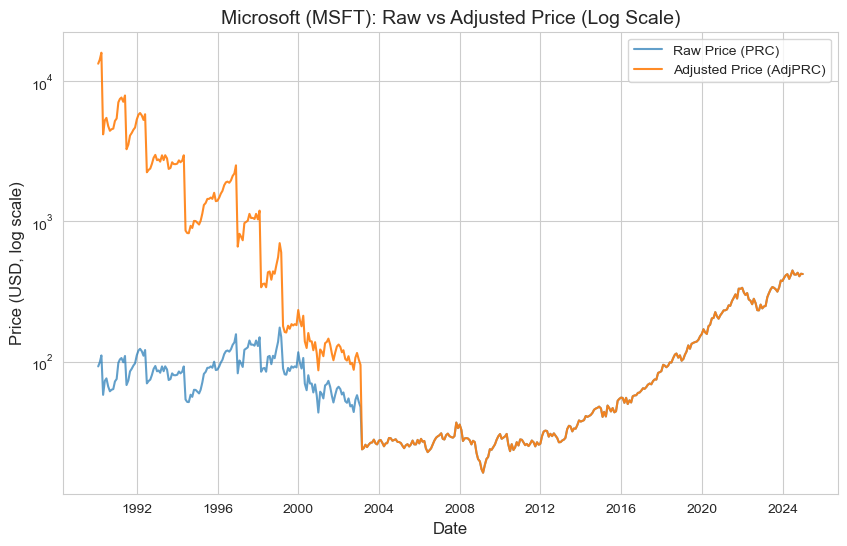

In [4]:
# ---------------------------
# 2. Plot raw vs. adjusted price
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(crsp_msf['date'], crsp_msf['prc'], label='Raw Price (PRC)', alpha=0.7)
plt.plot(crsp_msf['date'], crsp_msf['adjprc'], label='Adjusted Price (AdjPRC)', alpha=0.9)
plt.yscale('log')
plt.title("Microsoft (MSFT): Raw vs Adjusted Price (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Price (USD, log scale)")
plt.legend()
plt.show()

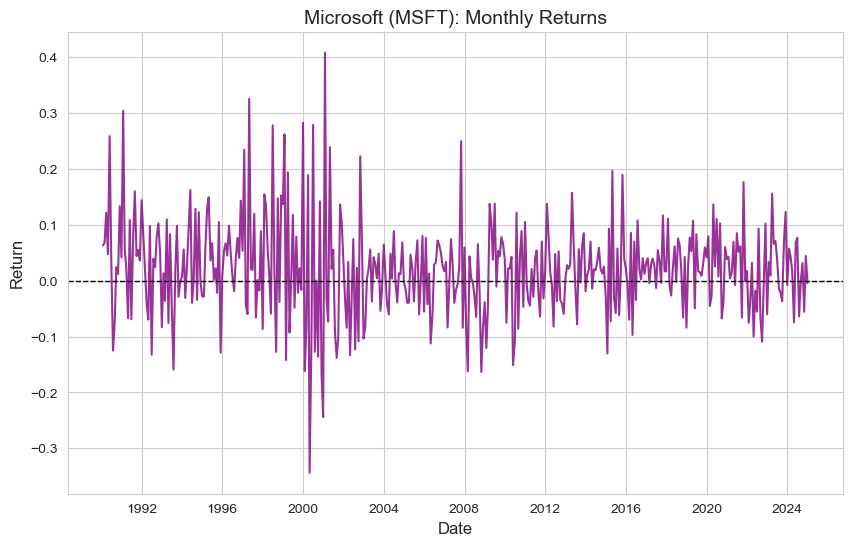

In [5]:
# ---------------------------
# 3. Plot monthly returns
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(crsp_msf['date'], crsp_msf['ret'], color='purple', alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Microsoft (MSFT): Monthly Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

In [6]:
# ---------------------------
# Fama-French Factors (Monthly)
# ---------------------------
ff_factors = db.raw_sql(f"""
    select date, mktrf, smb, hml, rf, cma, rmw, umd
    from ff.fivefactors_monthly
    where date between '{start_time}' and '{end_time}'
""")

In [8]:
# ===========================
# Compustat (Annual) for MSFT
# ===========================
gvkeys = "012141"  # gvkey for MSFT

# 1) Pull Compustat ANNUAL fundamentals
funda = db.raw_sql(f"""
    select gvkey, datadate, fyear, fyr,
           at,        -- total assets
           ceq,       -- common equity
           seq,       -- stockholders' equity
           txditc,    -- deferred taxes (balance sheet)
           pstk, pstkl, pstkrv,  -- preferred stock (various measures)
           sale, revt, cogs,     -- sales / revenue / COGS
           ib, ni, oiadp, oibdp, xint, xsga, dp,  -- income measures, depreciation, interest, SG&A
           dltt, dlc,              -- long-term and short-term debt
           capx,       -- capital expenditures
           che,        -- cash & equivalents
           act, lct,   -- current assets / current liabilities
           invt, ppent,-- inventory / net PPE
           xrd, xad,   -- R&D / advertising
           dvc         -- cash dividends (common)
    from comp.funda
    where gvkey = '{gvkeys}'  -- MSFT
      and indfmt = 'INDL' and datafmt = 'STD' and popsrc = 'D' and consol = 'C'
      and datadate between '1989-01-01' and '{end_time}'
""")

# 2) Prep
funda['datadate'] = pd.to_datetime(funda['datadate'], errors='coerce')
funda = funda.sort_values(['gvkey','datadate']).reset_index(drop=True)
num_cols = [c for c in funda.columns if c not in ['gvkey','datadate','fyear','fyr']]
for c in num_cols:
    funda[c] = pd.to_numeric(funda[c], errors='coerce')

# 3) Helper(s)
eps = 1e-12
def nz(x):  # safe denominator
    return x.where(x.abs() > eps, np.nan)

# --- Book Equity pieces (FF-style) ---
# BE = seq + txditc - pstk; if seq missing, fall back to (ceq + pstk) or at - lt (not pulled here)
pstk_fill = funda[['pstk','pstkl','pstkrv']].bfill(axis=1).iloc[:,0]
be = funda['seq']
be = be.fillna(funda['ceq'] + pstk_fill)  # fallback if seq missing
be = be + funda['txditc'].fillna(0) - pstk_fill.fillna(0)
funda['be'] = be.replace([np.inf,-np.inf], np.nan)

# 4) Lags for growth/ratios that need prior-year values
grp = funda.groupby('gvkey')
for col in ['at','sale','revt','be','act','lct','dltt','dlc','ppent','invt','che','capx','oiadp','oibdp','ib']:
    funda[f'L1_{col}'] = grp[col].shift(1)

# 5) Build **many** factors (annual, per-assets unless noted)

# Size
funda['size_log_at']          = np.log(nz(funda['at']))

# Book variables (use later with CRSP ME to form BM)
funda['be_pos']               = funda['be'].where(funda['be']>0)  # keep positive BE
# (BM itself should be computed after you merge with market equity from CRSP)

# Leverage
funda['lev_total_at']         = (funda['dltt'].fillna(0) + funda['dlc'].fillna(0)) / nz(funda['at'])
funda['lev_long_at']          = funda['dltt'] / nz(funda['at'])
funda['lev_short_at']         = funda['dlc'] / nz(funda['at'])

# Profitability
funda['roa']                  = funda['ib'] / nz(funda['at'])
funda['roe']                  = funda['ib'] / nz(funda['ceq'])
# Operating profitability (FF 2015 flavor; two denominators for flexibility)
funda['op_at']                = (funda['revt'] - funda['cogs'] - funda['xsga'].fillna(0) - funda['xint'].fillna(0)) / nz(funda['at'])
funda['op_be']                = (funda['revt'] - funda['cogs'] - funda['xsga'].fillna(0) - funda['xint'].fillna(0)) / nz(funda['be_pos'])
# Gross profitability (Novy-Marx)
funda['gross_prof_at']        = (funda['revt'] - funda['cogs']) / nz(funda['at'])
# Margins
funda['gross_margin']         = (funda['revt'] - funda['cogs']) / nz(funda['revt'])
funda['ebitda_margin']        = funda['oibdp'] / nz(funda['revt'])
funda['oper_margin']          = funda['oiadp'] / nz(funda['revt'])

# Growth / Investment
funda['asset_growth_yoy']     = (funda['at'] / nz(funda['L1_at'])) - 1
funda['sales_growth_yoy']     = (funda['sale'] / nz(funda['L1_sale'])) - 1
funda['capex_to_at']          = funda['capx'] / nz(funda['at'])
funda['capex_to_L1at']        = funda['capx'] / nz(funda['L1_at'])  # investment rate
funda['ppe_growth_yoy']       = (funda['ppent'] / nz(funda['L1_ppent'])) - 1
funda['inv_growth_yoy']       = (funda['invt'] / nz(funda['L1_invt'])) - 1

# Intangibles / Spending
funda['rd_to_at']             = funda['xrd'] / nz(funda['at'])
funda['adv_to_at']            = funda['xad'] / nz(funda['at'])

# Liquidity / Working capital
funda['cash_to_at']           = funda['che'] / nz(funda['at'])
funda['wc_to_at']             = ((funda['act'] - funda['lct']) / nz(funda['at']))
funda['dWC_to_L1at']          = (((funda['act'] - funda['lct']) - (funda['L1_act'] - funda['L1_lct'])) / nz(funda['L1_at']))

# Accrual proxies (simple)
# Sloan-style working-capital accruals proxy (no OANCF): delta(CA-CL) - delta(Cash) + delta(DLC)
funda['wc_accruals_to_at']    = (
    ((funda['act'] - funda['lct']) - (funda['L1_act'] - funda['L1_lct']))
    - (funda['che'] - funda['L1_che']).fillna(0)
    + (funda['dlc'] - funda['L1_dlc']).fillna(0)
) / nz(funda['at'])

# Capital structure / tangibility
funda['tangibility']          = funda['ppent'] / nz(funda['at'])
funda['inventory_to_at']      = funda['invt'] / nz(funda['at'])

# Payout
funda['payout_div_earn']      = funda['dvc'] / nz(funda['ib'])   # cap at reasonable bounds later

# 6) Keep tidy feature set
annual_features = funda[[
    'gvkey','datadate','fyear','fyr',
    # core building blocks
    'at','be','ceq','dltt','dlc','sale','revt','cogs','oibdp','oiadp','xint','xsga','capx','che','act','lct','ppent','invt','xrd','xad','dvc','ib',
    # features
    'size_log_at','be_pos',
    'lev_total_at','lev_long_at','lev_short_at',
    'roa','roe','op_at','op_be','gross_prof_at','gross_margin','ebitda_margin','oper_margin',
    'asset_growth_yoy','sales_growth_yoy','capex_to_at','capex_to_L1at','ppe_growth_yoy','inv_growth_yoy',
    'rd_to_at','adv_to_at','cash_to_at','wc_to_at','dWC_to_L1at','wc_accruals_to_at',
    'tangibility','inventory_to_at','payout_div_earn'
]].copy()

# 8) De-duplicate (just in case)
annual_features = annual_features.drop_duplicates(subset=['gvkey','datadate']).reset_index(drop=True)


In [ ]:
annual_features.head()

,gvkey,datadate,fyear,fyr,avail_date,at,be,ceq,dltt,dlc,...,inv_growth_yoy,rd_to_at,adv_to_at,cash_to_at,wc_to_at,dWC_to_L1at,wc_accruals_to_at,tangibility,inventory_to_at,payout_div_earn
0,012141,1989-06-30,1989,6,1989-12-31,720.598,561.78,561.78,0.0,25.419,...,<NA>,0.152956,0.031167,0.417419,0.43038,<NA>,<NA>,0.275917,0.052394,0.0
1,012141,1990-06-30,1990,6,1990-12-31,1105.349,918.563,918.563,0.0,6.5,...,0.471726,0.163401,0.031467,0.406422,0.482295,0.309428,0.050307,0.294429,0.050269,0.0
2,012141,1991-06-30,1991,6,1991-12-31,1644.184,1350.831,1350.831,0.0,19.456,...,-0.152236,0.143163,0.032086,0.417419,0.447121,0.182789,-0.013426,0.322465,0.02865,0.0
3,012141,1992-06-30,1992,6,1992-12-31,2639.903,2192.958,2192.958,<NA>,8.324,...,0.822974,0.133396,0.032913,0.509451,0.501063,0.357386,-0.031103,0.290401,0.032529,0.0
4,012141,1993-06-30,1993,6,1993-12-31,3805.0,3242.0,3242.0,<NA>,0.0,...,0.478928,0.123522,0.026544,0.60184,0.601051,0.365256,0.002843,0.227858,0.033377,0.0


In [9]:
# Close the database connection
db.close()

### Merge three data

In [10]:
crsp = crsp_msf.copy()          # your MSFT monthly (permno, date, ret, prc, shrout, adjprc, me, ...)
ff   = ff_factors.copy()        # your Fama-French monthly (date, mktrf, smb, hml, rf, cma, rmw, umd)
comp = annual_features.copy()   # from the Compustat-annual builder (gvkey, datadate, avail_date, features...)

# --- 0) Date normalization (monthly) ---
crsp['date_m'] = pd.to_datetime(crsp['date']).dt.to_period('M').dt.to_timestamp('M')

# Fama–French (often already month-end; normalize anyway)
ff['date_m'] = pd.to_datetime(ff['date']).dt.to_period('M').dt.to_timestamp('M')

# Compustat annual features (built earlier for MSFT only)
comp['date_m'] = pd.to_datetime(comp['datadate']).dt.to_period('M').dt.to_timestamp('M')

# (Optional but recommended) enforce a publication lag to avoid look-ahead:
# e.g., shift accounting info by +4 months:
# compa_features['pub_m'] = (compa_features['date_m'] + pd.offsets.MonthEnd(4))
# and then use 'pub_m' as the right key in merge_asof below.
# For now we use 'date_m' directly with backward matching.

# --- 1) CRSP  ×  Compustat (as-of, backward) ---
crsp_sorted   = crsp.sort_values('date_m')
comp_sorted  = comp.sort_values('date_m')

merged_ccm = pd.merge_asof(
    crsp_sorted,
    comp_sorted,
    left_on='date_m',
    right_on='date_m',
    direction='backward'   # use most recent Compustat at or before this month
)

# --- 2) Add Fama–French factors by month ---
merged_all = merged_ccm.merge(
    ff[['date_m','mktrf','smb','hml','rf','cma','rmw','umd']],
    on='date_m',
    how='left'
)

# Optional: keep one row per month with the key variables you care about
# (you likely have one per month already for MSFT)
# Example preview:
cols_preview = ['date_m','prc','adjprc','ret','mktrf','smb','hml','cma','rmw','umd','rf']
merged_all[ [c for c in cols_preview if c in merged_all.columns] ].head()


,date_m,prc,adjprc,ret,mktrf,smb,hml,cma,rmw,umd,rf
0,1990-01-31,92.5,13320.0,0.063218,-0.078,-0.0121,0.0083,0.014,-0.0112,-0.0298,0.0057
1,1990-02-28,98.75,14220.0,0.067568,0.0111,0.0115,0.0065,-0.0061,-0.0004,-0.0051,0.0057
2,1990-03-31,110.75,15948.0,0.121519,0.0183,0.0159,-0.029,-0.0094,0.0199,0.0172,0.0064
3,1990-04-30,58.0,4176.0,0.047404,-0.0336,-0.0035,-0.0257,-0.01,0.0178,0.0228,0.0069
4,1990-05-31,73.0,5256.0,0.258621,0.0844,-0.0241,-0.0389,-0.0163,0.0168,0.0314,0.0068


### Preprossing data

In [11]:
# 1) Replace +/- inf with NaN (keep NaNs so we can impute later)
merged_all = merged_all.replace([np.inf, -np.inf], np.nan)

# 2) Optional hard guard for returns: values below -100% or above +500% are likely data issues
if 'ret' in merged_all:
    bad = (merged_all['ret'] < -1.0) | (merged_all['ret'] > 5.0)
    merged_all.loc[bad, 'ret'] = np.nan

merged_all['excess_ret'] = merged_all['ret'] - merged_all['rf']
merged_all['excess_ret_fwd1'] = merged_all['excess_ret'].shift(-1)

# 3) Train/Test split by calendar month (adjust dates to your needs)
train_mask = (merged_all['date_m'] <= '2018-12-31')
test_mask  = (merged_all['date_m'] >= '2019-01-01')

# 4) Feature set: Compustat annual features + FF factors (factors already in decimals)
factor_cols = ['mktrf','smb','hml','cma','rmw','umd']
comp_cols = [
    'size_log_at','be_pos','lev_total_at','lev_short_at','roa','roe','op_at','op_be',
    'gross_prof_at','gross_margin','ebitda_margin','oper_margin','asset_growth_yoy','sales_growth_yoy',
    'capex_to_at','capex_to_L1at','ppe_growth_yoy','rd_to_at','cash_to_at',
    'wc_to_at','dWC_to_L1at','wc_accruals_to_at','tangibility','inventory_to_at','payout_div_earn'
]
crsp_cols = ['ret_l1','mom_12_1','vol_6m','turnover','illiq','log_prc']
X_cols = [c for c in (comp_cols + factor_cols + crsp_cols) if c in merged_all.columns]

# 4a) Coerce selected feature columns to numeric to eliminate pd.NA/object dtypes
merged_all[X_cols] = merged_all[X_cols].apply(pd.to_numeric, errors='coerce')
merged_all.dropna(subset=X_cols, how='any', inplace=True)

# 5) Build a preprocessing pipeline: median imputation (handles np.nan) + standardization
preprocess_linear = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
preprocess_tree   = make_pipeline(SimpleImputer(strategy='median'))  # no scaler for trees

# Final train/test matrices
X_train_df = merged_all.loc[train_mask, X_cols]
X_test_df  = merged_all.loc[test_mask,  X_cols]
y_train = merged_all.loc[train_mask, 'excess_ret_fwd1'].astype(np.float64)
y_test  = merged_all.loc[test_mask,  'excess_ret_fwd1'].astype(np.float64)

# Example: prepare data for linear vs tree models
X_train_linear = preprocess_linear.fit_transform(X_train_df)
X_test_linear  = preprocess_linear.transform(X_test_df)

X_train_tree = preprocess_tree.fit_transform(X_train_df)
X_test_tree  = preprocess_tree.transform(X_test_df)

## Prepare Evaluation Function

In [12]:
def evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    *,
    loss: str = "squared",             # "squared" or "absolute"
    annualize: bool = True,
    periods_per_year: int = 12,
) -> Dict[str, Any]:
    """
    Minimal evaluation:
      - Fits `model` and times `.fit()`
      - Predicts on test
      - Computes RMSE, MAE, Hit Ratio, OOS R^2, Sharpe (monthly & annualized)
      - Returns arrays needed for DM test (y_test, y_pred, y_bench, errors, losses)

    Notes:
      - Assumes y is (next-month) excess return if you want Sharpe to be meaningful.
      - Drops rows with NaN/inf in y_test or y_pred (mask is returned).
    """
    y_train = np.asarray(y_train, dtype=float)
    y_test_arr = np.asarray(y_test, dtype=float)

    # 1) Fit & time
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    fit_time_sec = time.perf_counter() - t0

    # 2) Predict
    y_pred_full = np.asarray(model.predict(X_test), dtype=float)

    # 3) Valid mask and align
    mask = np.isfinite(y_test_arr) & np.isfinite(y_pred_full)
    y_t  = y_test_arr[mask]
    yhat = y_pred_full[mask]

    # 4) Errors & loss (DM-ready)
    e_model = y_t - yhat
    e_bench = y_t
    if loss == "squared":
        loss_model = e_model**2
        loss_bench = e_bench**2
    elif loss == "absolute":
        loss_model = np.abs(e_model)
        loss_bench = np.abs(e_bench)
    else:
        raise ValueError("loss must be 'squared' or 'absolute'.")

    # 5) Metrics
    rmse = float(np.sqrt(np.mean(e_model**2))) if len(e_model) else np.nan
    mae  = float(np.mean(np.abs(e_model)))     if len(e_model) else np.nan
    hit_ratio = float(np.mean(np.sign(yhat) == np.sign(y_t))) if len(y_t) else np.nan

    sse_model = float(np.sum(e_model**2))
    sse_bench = float(np.sum(e_bench**2))
    r2_oos = 1.0 - sse_model / sse_bench if sse_bench > 0 else np.nan

    strat_ret = np.sign(yhat) * y_t
    mu = np.mean(strat_ret) if len(strat_ret) else np.nan
    sd = np.std(strat_ret, ddof=1) if len(strat_ret) > 1 else np.nan
    sharpe_m = float(mu / sd) if (sd and np.isfinite(sd)) else np.nan
    sharpe_a = float(sharpe_m * np.sqrt(periods_per_year)) if (annualize and np.isfinite(sharpe_m)) else sharpe_m

    return {
        "metrics": {
            "rmse": rmse,
            "mae": mae,
            "hit_ratio": hit_ratio,
            "r2_oos": float(r2_oos),
            "sharpe_monthly": sharpe_m,
            "sharpe_annualized": sharpe_a,
            "fit_time_sec": float(fit_time_sec),
        },
        "fitted_model": model,   # trained model
        # DM-ready series
        "y_test": y_t,
        "y_pred": yhat,
        "errors_model": e_model,
        "errors_bench": e_bench,
        "loss_model": loss_model,
        "loss_bench": loss_bench,
        "mask_bool": mask,       # in case you need to align with original index
    }

In [13]:
def _norm_cdf(x):
    # Normal CDF without scipy
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

def dm_test_from_predictions(
    y, yhat_a, yhat_b, *, loss="squared", h=1, lag=None, alternative="two-sided", use_hln=True
):
    """
    Diebold-Mariano test comparing forecast accuracy of model A vs model B.

    Inputs (1D arrays, same length):
      y        : realized target (e.g., next-month excess return)
      yhat_a   : predictions from model A
      yhat_b   : predictions from model B

    Params:
      loss     : "squared" or "absolute"
      h        : forecast horizon (1 for 1-step-ahead)
      lag      : NW lag for HAC variance; default = h-1 (set a small integer like 3–6 if you prefer)
      alternative : "two-sided" | "greater" (A > B) | "less" (A < B)
      use_hln  : small-sample HLN correction (Harvey–Leybourne–Newbold, 1997)

    Returns:
      {"DM": dm_stat, "p_value": p, "T_eff": T, "mean_d": d_bar}
    """
    y = np.asarray(y, dtype=float)
    a = np.asarray(yhat_a, dtype=float)
    b = np.asarray(yhat_b, dtype=float)

    mask = np.isfinite(y) & np.isfinite(a) & np.isfinite(b)
    y, a, b = y[mask], a[mask], b[mask]
    T = len(y)
    if T < 5:
        return {"DM": np.nan, "p_value": np.nan, "T_eff": T, "mean_d": np.nan}

    e_a = y - a
    e_b = y - b
    if loss == "squared":
        L_a = e_a**2
        L_b = e_b**2
    elif loss == "absolute":
        L_a = np.abs(e_a)
        L_b = np.abs(e_b)
    else:
        raise ValueError("loss must be 'squared' or 'absolute'")

    d = L_a - L_b
    d_bar = float(np.mean(d))

    # Newey–West long-run variance of d_t
    if lag is None:
        lag = max(h - 1, 0)
    d_c = d - d_bar
    gamma0 = np.dot(d_c, d_c) / T
    lrvar = gamma0
    for k in range(1, lag + 1):
        w = 1.0 - k / (lag + 1.0)
        cov = np.dot(d_c[k:], d_c[:-k]) / T
        lrvar += 2.0 * w * cov

    # DM statistic
    denom = np.sqrt(lrvar / T) if lrvar > 0 else np.nan
    dm = d_bar / denom if denom and np.isfinite(denom) else np.nan

    # HLN small-sample correction (recommended)
    if use_hln and np.isfinite(dm):
        k = ((T + 1 - 2*h + (h*(h-1))/T) / T) ** 0.5
        dm = dm * k

    # p-value under (approx) N(0,1)
    if not np.isfinite(dm):
        p = np.nan
    else:
        if alternative == "two-sided":
            p = 2.0 * (1.0 - _norm_cdf(abs(dm)))
        elif alternative == "greater":  # A better than B
            p = 1.0 - _norm_cdf(dm)
        elif alternative == "less":     # A worse than B
            p = _norm_cdf(dm)
        else:
            raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    return {"DM": float(dm), "p_value": float(p), "T_eff": int(T), "mean_d": d_bar}

## Ordinary Least Squares (OLS)

**Idea:**  
Ordinary Least Squares (OLS) is the baseline linear regression method. It estimates the relationship between a dependent variable $y$ and explanatory variables $X$ by fitting a straight line (or hyperplane) that minimizes the **sum of squared errors**.

**Model:**
$$
y_i = \alpha + X_i^\top \beta + \varepsilon_i
$$

- $y_i$: outcome (e.g., next-month excess return)  
- $X_i$: vector of predictors (firm characteristics, factors)  
- $\beta$: coefficients to be estimated  
- $\varepsilon_i$: error term (unexplained part)

**Estimation Principle:**  
OLS chooses $\hat{\beta}$ to minimize
$$
\min_{\beta} \sum_{i=1}^n \left(y_i - X_i^\top \beta \right)^2
$$

**Interpretation:**  
- Each $\beta_j$ shows how a one-unit change in predictor $X_j$ affects the expected outcome, holding others constant.  
- Provides a simple and interpretable baseline.  

**Limitations:**  
- Assumes linear relationships.  
- Sensitive to multicollinearity and outliers.  
- May overfit when predictors are high-dimensional and noisy.

In [14]:
# Standardized data for linear models
ols = LinearRegression()
ols_results = evaluate_model(ols, X_train_linear, y_train, X_test_linear, y_test)

# 4) Print evaluation summary
print("=== OLS Test Results ===")

all_result_df = pd.DataFrame(ols_results['metrics'], index=[0])
all_result_df['Model'] = 'OLS'

display(all_result_df)

=== OLS Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS


In [15]:
# 2) Print coefficients (standardized)
coef_df = pd.DataFrame({
    "feature": X_cols,
    "coef_std": ols_results['fitted_model'].coef_
}).sort_values("coef_std", key=lambda s: s.abs(), ascending=False)

print("\n=== OLS Coefficients (standardized) ===")
print(coef_df.to_string(index=False))


=== OLS Coefficients (standardized) ===
          feature  coef_std
       cash_to_at  0.237923
      capex_to_at  0.222070
         wc_to_at -0.211716
    ebitda_margin  0.194782
      oper_margin -0.185954
              roa  0.158954
     lev_total_at  0.138266
      tangibility -0.117669
              roe -0.094225
     lev_short_at -0.084545
          log_prc -0.083467
            op_be -0.081037
    capex_to_L1at -0.071824
         rd_to_at  0.064853
wc_accruals_to_at  0.053365
     gross_margin -0.050091
            op_at  0.035632
    gross_prof_at  0.029791
      dWC_to_L1at -0.028444
  payout_div_earn -0.026785
   ppe_growth_yoy -0.022706
         mom_12_1 -0.021237
           be_pos -0.012806
      size_log_at  0.012759
              rmw -0.012077
 sales_growth_yoy  0.010890
  inventory_to_at  0.007729
            mktrf -0.007399
              cma  0.005044
           vol_6m -0.004640
              hml -0.004343
 asset_growth_yoy  0.003392
           ret_l1 -0.003190
       

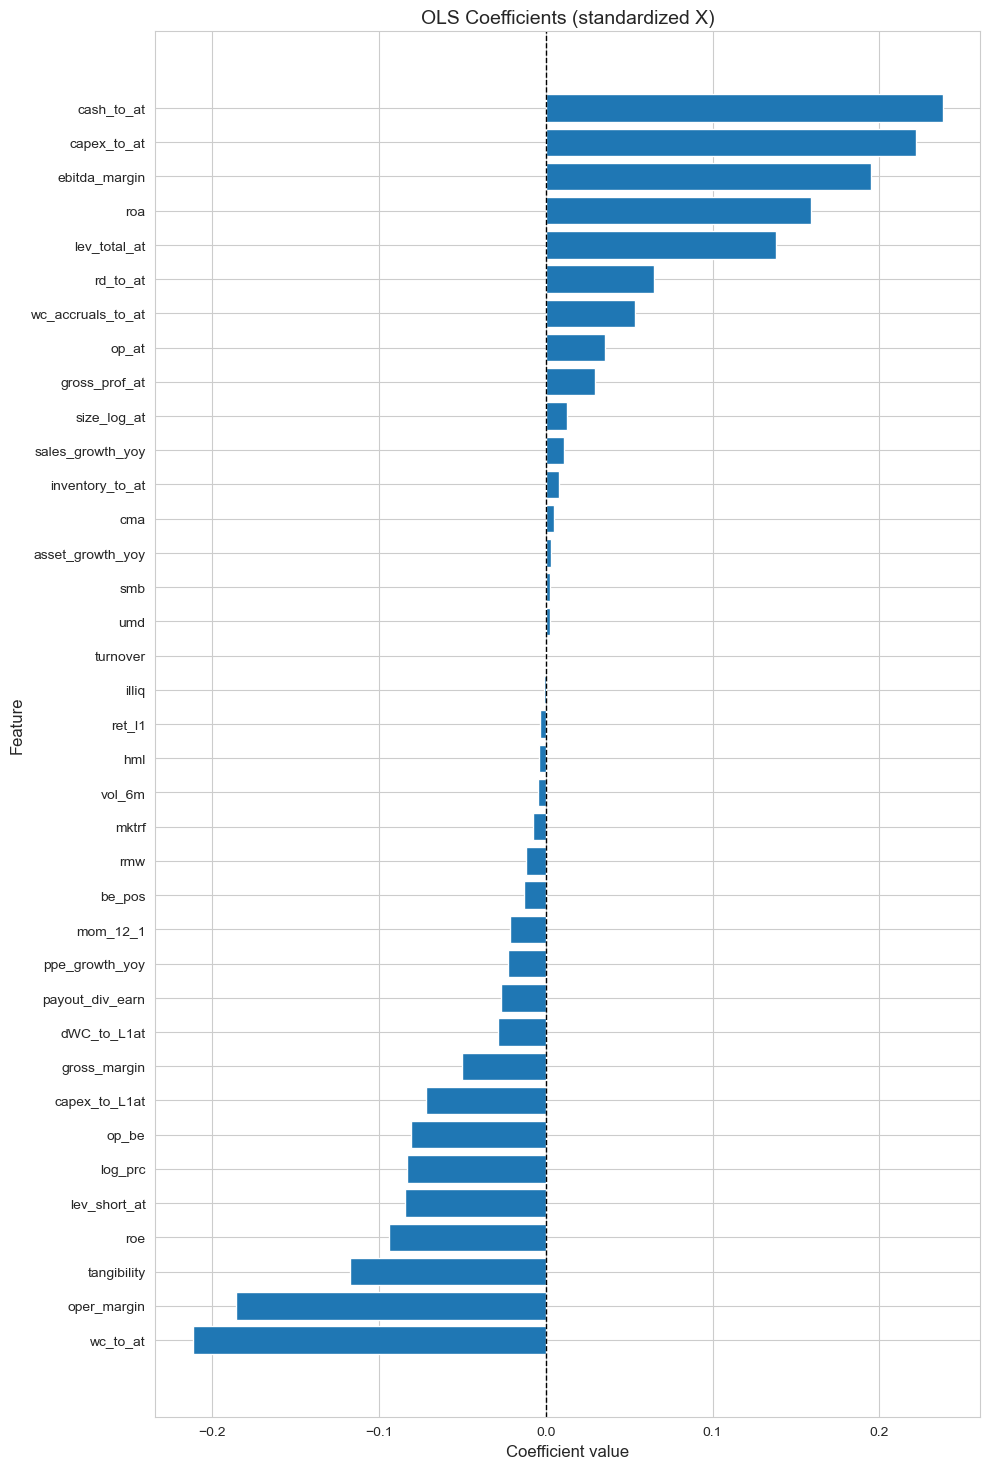

In [16]:
ols_est = ols_results['fitted_model']
coefs = np.asarray(ols_est.coef_, dtype=float).ravel()
coef_df = (
    pd.DataFrame({"feature": X_cols, "coef_std": coefs})
      .sort_values("coef_std", ascending=True)  # from low → high
      .reset_index(drop=True)
)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(coef_df))))
plt.barh(coef_df["feature"], coef_df["coef_std"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("OLS Coefficients (standardized X)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Regularized Regression: Ridge, Lasso, and Elastic Net

**Motivation:**  
Ordinary Least Squares (OLS) can overfit when predictors are **high-dimensional**, **noisy**, or **highly correlated**.  
Regularization methods add a penalty to the loss function, shrinking coefficients to improve generalization.

---

### Lasso Regression (L1 penalty)
Lasso uses the **sum of absolute coefficients** as a penalty:
$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i^\top \beta)^2 + \lambda \sum_{j=1}^p |\beta_j|
$$

- Performs **variable selection**: some coefficients shrink exactly to zero.  
- Useful when we believe only a subset of predictors are truly important.  
- Tends to select one variable from a group of correlated variables.


In [17]:
# === Lasso Regression ===
lasso = Lasso(alpha=0.005, fit_intercept=True, max_iter=5000, random_state=42)
lasso_results = evaluate_model(
    lasso, X_train_linear, y_train, X_test_linear, y_test
)

all_result_df.loc[all_result_df.shape[0]] = {
    **lasso_results['metrics'],
    'Model': f"Lasso"
}
print("=== Lasso Test Results ===")
display(all_result_df)


=== Lasso Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso


In [18]:
# 2) Print coefficients (standardized)
coef_df = pd.DataFrame({
    "feature": X_cols,
    "coef_std": lasso_results['fitted_model'].coef_
}).sort_values("coef_std", key=lambda s: s.abs(), ascending=False)
nz = np.count_nonzero(lasso_results["fitted_model"].coef_)
print("Non-zero coefficients:", nz, "/", len(X_cols))

print("\n=== Lasso Coefficients (standardized) ===")
print(coef_df.loc[coef_df["coef_std"] != 0.0].to_string(index=False))

Non-zero coefficients: 7 / 37

=== Lasso Coefficients (standardized) ===
          feature  coef_std
wc_accruals_to_at -0.005325
              rmw -0.004317
       cash_to_at  0.002226
      tangibility  0.002201
           ret_l1 -0.000628
         rd_to_at  0.000143
 asset_growth_yoy  0.000084


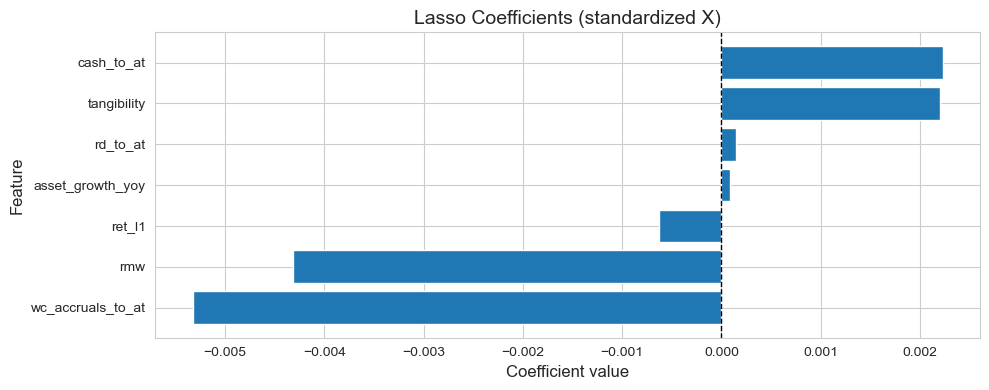

In [19]:
lasso_est = lasso_results['fitted_model']
coefs = np.asarray(lasso_est.coef_, dtype=float).ravel()
coef_df = (
    pd.DataFrame({"feature": X_cols, "coef_std": coefs})
      .sort_values("coef_std", ascending=True)  # from low → high
      .reset_index(drop=True)
)
coef_df = coef_df[coef_df["coef_std"] != 0.0].reset_index(drop=True)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(coef_df))))
plt.barh(coef_df["feature"], coef_df["coef_std"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Lasso Coefficients (standardized X)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Ridge Regression (L2 penalty)
Ridge shrinks coefficients by adding the **sum of squared coefficients** as a penalty:
$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i^\top \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2
$$

- Keeps all predictors, but shrinks them toward zero.  
- Works well when predictors are correlated.  
- Tuning parameter $\lambda$ controls the amount of shrinkage.
---

### Elastic Net (L1 + L2 penalty)
Elastic Net combines both L1 and L2 penalties:
$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i^\top \beta)^2 + \lambda_1 \sum_{j=1}^p |\beta_j| + \lambda_2 \sum_{j=1}^p \beta_j^2
$$

- Balances **shrinkage** (Ridge) and **variable selection** (Lasso).  
- Works better than Lasso when predictors are highly correlated.  
- Controlled by two hyperparameters: $\lambda_1$ (L1 strength) and $\lambda_2$ (L2 strength).


In [20]:
# === Ridge Regression ===

# 1) Choose alpha via CV
alphas = np.logspace(-4, 4, 50)  # from 1e-4 to 1e4
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=False)
ridge_cv.fit(X_train_linear, y_train)
best_alpha = float(ridge_cv.alpha_)
print(f"[RidgeCV] best alpha = {best_alpha:.6g}")

# 4) Refit Ridge with best alpha
ridge = Ridge(alpha=best_alpha, fit_intercept=True, random_state=42)
ridge_results = evaluate_model(
    ridge, X_train_linear, y_train, X_test_linear, y_test, 
)

all_result_df.loc[all_result_df.shape[0]] = {
    **ridge_results['metrics'],
    'Model': f"Ridge(alpha={best_alpha:.3g})"
}

print("=== Ridge Test Results ===")
display(all_result_df)


[RidgeCV] best alpha = 10000
=== Ridge Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso
2,0.061895,0.050427,0.633803,0.093382,0.332173,1.150679,0.002112,Ridge(alpha=1e+04)


In [21]:

# 2) Print coefficients (standardized)
coef_df = pd.DataFrame({
    "feature": X_cols,
    "coef_std": ridge_results['fitted_model'].coef_
}).sort_values("coef_std", key=lambda s: s.abs(), ascending=False)

print("\n=== Ridge Coefficients (standardized) ===")
print(coef_df.to_string(index=False))


=== Ridge Coefficients (standardized) ===
          feature  coef_std
wc_accruals_to_at -0.000361
              rmw -0.000317
       cash_to_at  0.000304
 asset_growth_yoy  0.000241
         rd_to_at  0.000201
 sales_growth_yoy  0.000193
      tangibility  0.000188
    gross_prof_at  0.000185
           be_pos -0.000182
         wc_to_at  0.000179
      size_log_at -0.000178
      dWC_to_L1at  0.000176
           ret_l1 -0.000172
            op_at  0.000158
    capex_to_L1at  0.000153
      capex_to_at  0.000147
            op_be  0.000133
         mom_12_1  0.000132
           vol_6m -0.000121
      oper_margin -0.000120
  payout_div_earn -0.000119
              roa  0.000109
              hml -0.000107
         turnover -0.000105
     lev_short_at  0.000102
    ebitda_margin -0.000101
     lev_total_at  0.000097
          log_prc  0.000091
              roe  0.000084
              smb  0.000081
            illiq  0.000079
              cma  0.000075
            mktrf -0.000053
   pp

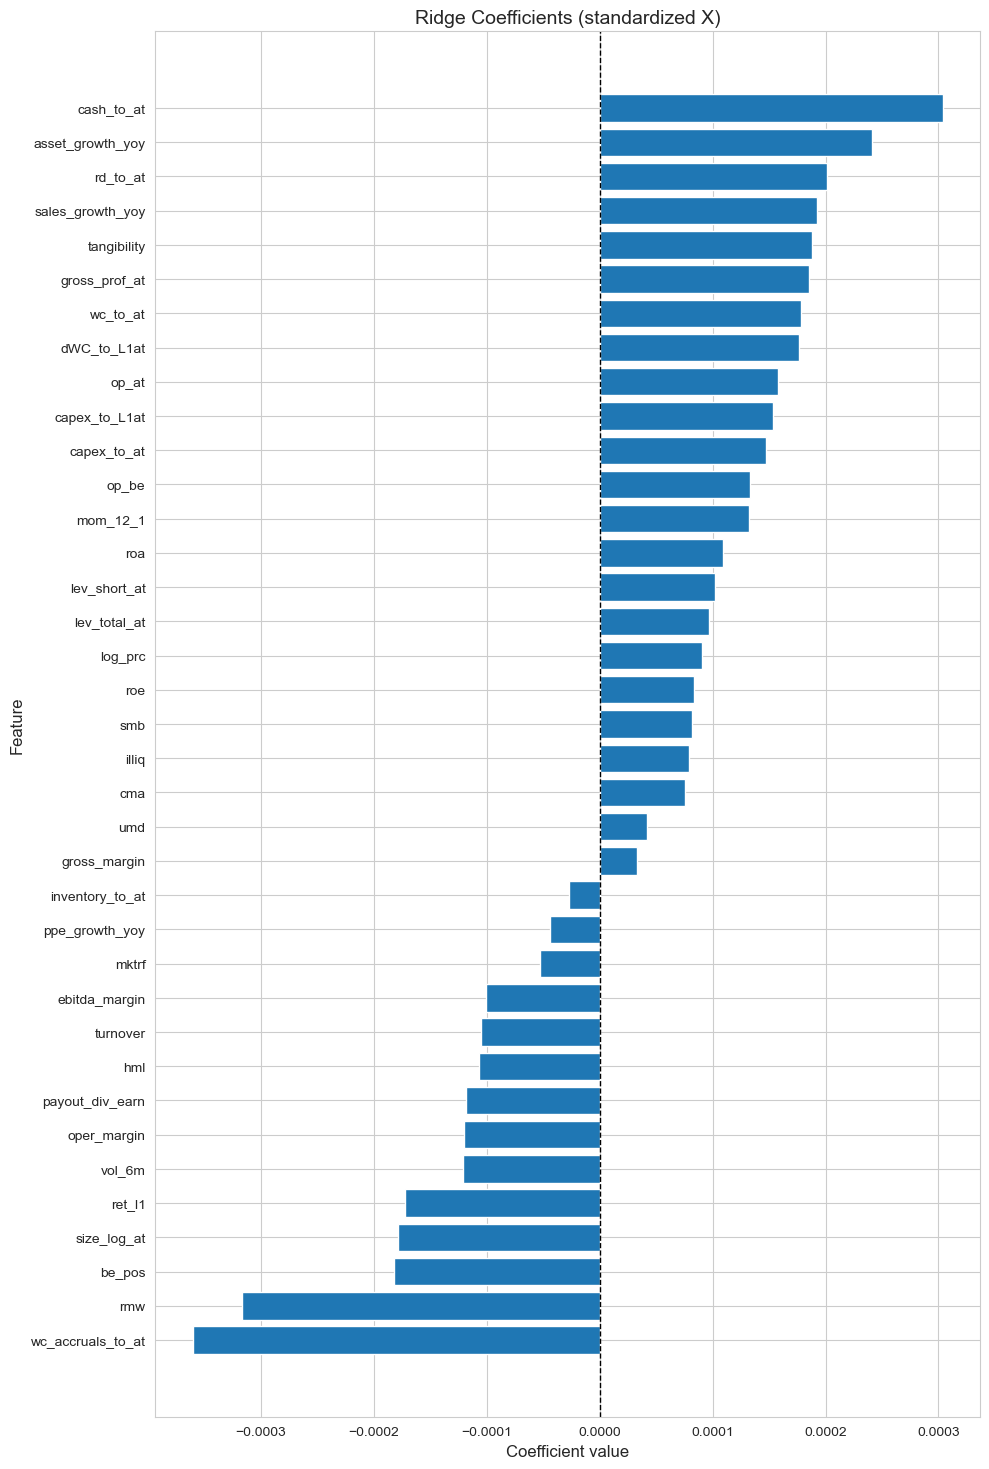

In [22]:
ridge_est = ridge_results['fitted_model']
coefs = np.asarray(ridge_est.coef_, dtype=float).ravel()
coef_df = (
    pd.DataFrame({"feature": X_cols, "coef_std": coefs})
      .sort_values("coef_std", ascending=True)  # from low → high
      .reset_index(drop=True)
)
coef_df = coef_df[coef_df["coef_std"] != 0.0].reset_index(drop=True)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(coef_df))))
plt.barh(coef_df["feature"], coef_df["coef_std"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Ridge Coefficients (standardized X)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
# === Elastic Net Regression ===
# 1) Refit Elastic Net using the best params (for fair FitTime measurement)
enet = ElasticNet(
    alpha=0.001,
    l1_ratio=0.5,
    max_iter=10000,
    fit_intercept=True,
    random_state=42
)

enet_results = evaluate_model(
    enet, X_train_linear, y_train, X_test_linear, y_test,
)


all_result_df.loc[all_result_df.shape[0]] = {
    **enet_results['metrics'],
    'Model': f"ElasticNet"
}

print("=== ElasticNet Test Results ===")
display(all_result_df)


=== ElasticNet Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso
2,0.061895,0.050427,0.633803,0.093382,0.332173,1.150679,0.002112,Ridge(alpha=1e+04)
3,0.142404,0.122288,0.436620,-3.799055,-0.122692,-0.425017,0.003734,ElasticNet


In [24]:

enet_model = enet_results['fitted_model']
feature_cols = X_cols[:]

# 3) Coefficient inspection (standardized features)
coef = enet_model.coef_
nz_mask = coef != 0
print(f"Nonzero coefficients: {int(nz_mask.sum())} / {len(coef)}")

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef_std": coef
}).sort_values("coef_std", key=lambda s: s.abs(), ascending=False)

print("\n=== Elastic Net Coefficients (standardized) ===")
print(coef_df[coef_df["coef_std"] != 0.0].to_string(index=False))


Nonzero coefficients: 25 / 37

=== Elastic Net Coefficients (standardized) ===
         feature  coef_std
         log_prc -0.036225
      cash_to_at  0.030699
    lev_total_at  0.029306
        rd_to_at  0.028538
asset_growth_yoy  0.017322
   ebitda_margin  0.016149
  ppe_growth_yoy  0.011138
             rmw -0.011016
sales_growth_yoy  0.010585
    lev_short_at  0.009735
     dWC_to_L1at -0.008989
             cma  0.006385
        mom_12_1 -0.006287
           mktrf -0.005697
          ret_l1 -0.005534
 inventory_to_at -0.004453
     size_log_at -0.003533
             hml -0.003010
          vol_6m  0.002004
        turnover -0.001976
 payout_div_earn -0.001884
             umd  0.001443
             smb  0.001037
           illiq  0.000670
          be_pos -0.000514


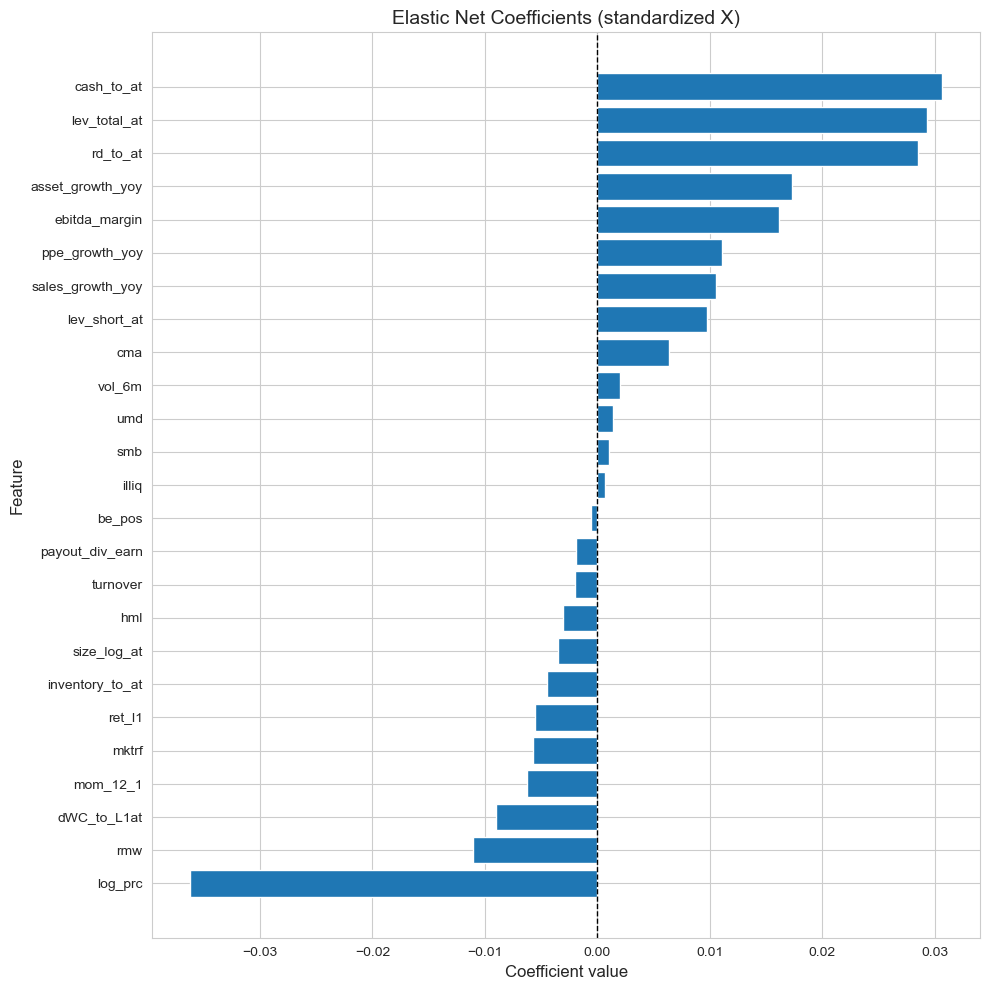

In [25]:
coefs = np.asarray(enet_model.coef_, dtype=float).ravel()
coef_df = (
    pd.DataFrame({"feature": X_cols, "coef_std": coefs})
      .sort_values("coef_std", ascending=True)  # from low → high
      .reset_index(drop=True)
)
coef_df = coef_df[coef_df["coef_std"] != 0.0].reset_index(drop=True)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(coef_df))))
plt.barh(coef_df["feature"], coef_df["coef_std"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Elastic Net Coefficients (standardized X)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Random Forest: Intuition and Application

**Random Forest (RF)** is an ensemble learning method introduced by Breiman (2001).  
It builds on decision trees but improves stability and accuracy through **bagging** and **random feature selection**.

- **Decision Tree Basics**:  
  Splits data recursively into regions based on predictor values.  
  Simple and interpretable, but prone to **overfitting** and high variance.

- **Random Forest Mechanics**:  
  - **Bagging**: Each tree is trained on a bootstrap sample of the data.  
  - **Feature Subsampling**: At each split, only a random subset of features is considered.  
  - **Ensemble Prediction**:  
    - Regression: average of predictions across trees.  
    - Classification: majority vote across trees.  

- **Strengths**:  
  - Captures **nonlinearities** and **interactions** automatically.  
  - Robust to noise and overfitting by averaging many decorrelated trees.  
  - Scales well to high-dimensional datasets; training is parallelizable.  
  - Provides **feature importance** measures useful in finance.

- **Weaknesses**:  
  - Acts like a **black box**; less interpretable than OLS or Lasso.  
  - May be biased toward strong predictors if not tuned carefully.  
  - Less efficient for sparse, very high-dimensional data.

**Finance Takeaway**:  
Random Forest is a strong off-the-shelf model for stock return prediction, especially when relationships are **nonlinear** and **noisy**.

In [26]:
# 1) Define RF model (sensible defaults for classroom demo)
n_estimaters = 600
rf = RandomForestRegressor(
    n_estimators=n_estimaters,          # a bit larger; still fast
    criterion="absolute_error",# robust to outliers
    max_depth=8,               # cap depth to cut variance
    min_samples_leaf=8,        # ≥5–10 works well on small samples
    min_samples_split=8,
    max_features=0.5,          # try 0.3–0.6
    bootstrap=True,
    max_samples=0.8,           # subsample rows per tree
    oob_score=True,            # quick sanity check on train (R^2 vs mean)
    n_jobs=-1,
    random_state=42
)

# 2) Fit & evaluate
rf_results = evaluate_model(
    rf, X_train_tree, y_train, X_test_tree, y_test
)

all_result_df.loc[all_result_df.shape[0]] = {
    **rf_results['metrics'],
    'Model': f"RandomForest(n={n_estimaters})"
}

print("=== RandomForest Test Results ===")
display(all_result_df)

=== RandomForest Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso
2,0.061895,0.050427,0.633803,0.093382,0.332173,1.150679,0.002112,Ridge(alpha=1e+04)
3,0.142404,0.122288,0.436620,-3.799055,-0.122692,-0.425017,0.003734,ElasticNet
4,0.061949,0.050238,0.661972,0.091803,0.344364,1.192912,0.845893,RandomForest(n=600)


In [27]:
# 3) Feature importances
rf_model = rf_results['fitted_model']
fi = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\n=== Random Forest Feature Importances ===")
print(fi.to_string(index=False))


=== Random Forest Feature Importances ===
          feature  importance
              rmw    0.091319
           ret_l1    0.079715
            mktrf    0.067482
              cma    0.060162
              umd    0.058701
          log_prc    0.058042
              hml    0.054107
         mom_12_1    0.049903
           vol_6m    0.049578
         turnover    0.041264
              smb    0.041125
            illiq    0.039696
wc_accruals_to_at    0.025613
    ebitda_margin    0.019359
   ppe_growth_yoy    0.019234
      capex_to_at    0.017256
      oper_margin    0.017198
         wc_to_at    0.017127
       cash_to_at    0.016591
      tangibility    0.015670
 asset_growth_yoy    0.015250
    capex_to_L1at    0.014686
            op_be    0.014544
              roe    0.013612
     gross_margin    0.012456
  inventory_to_at    0.011106
      dWC_to_L1at    0.010782
     lev_short_at    0.009251
 sales_growth_yoy    0.008677
         rd_to_at    0.008285
              roa    0.0081

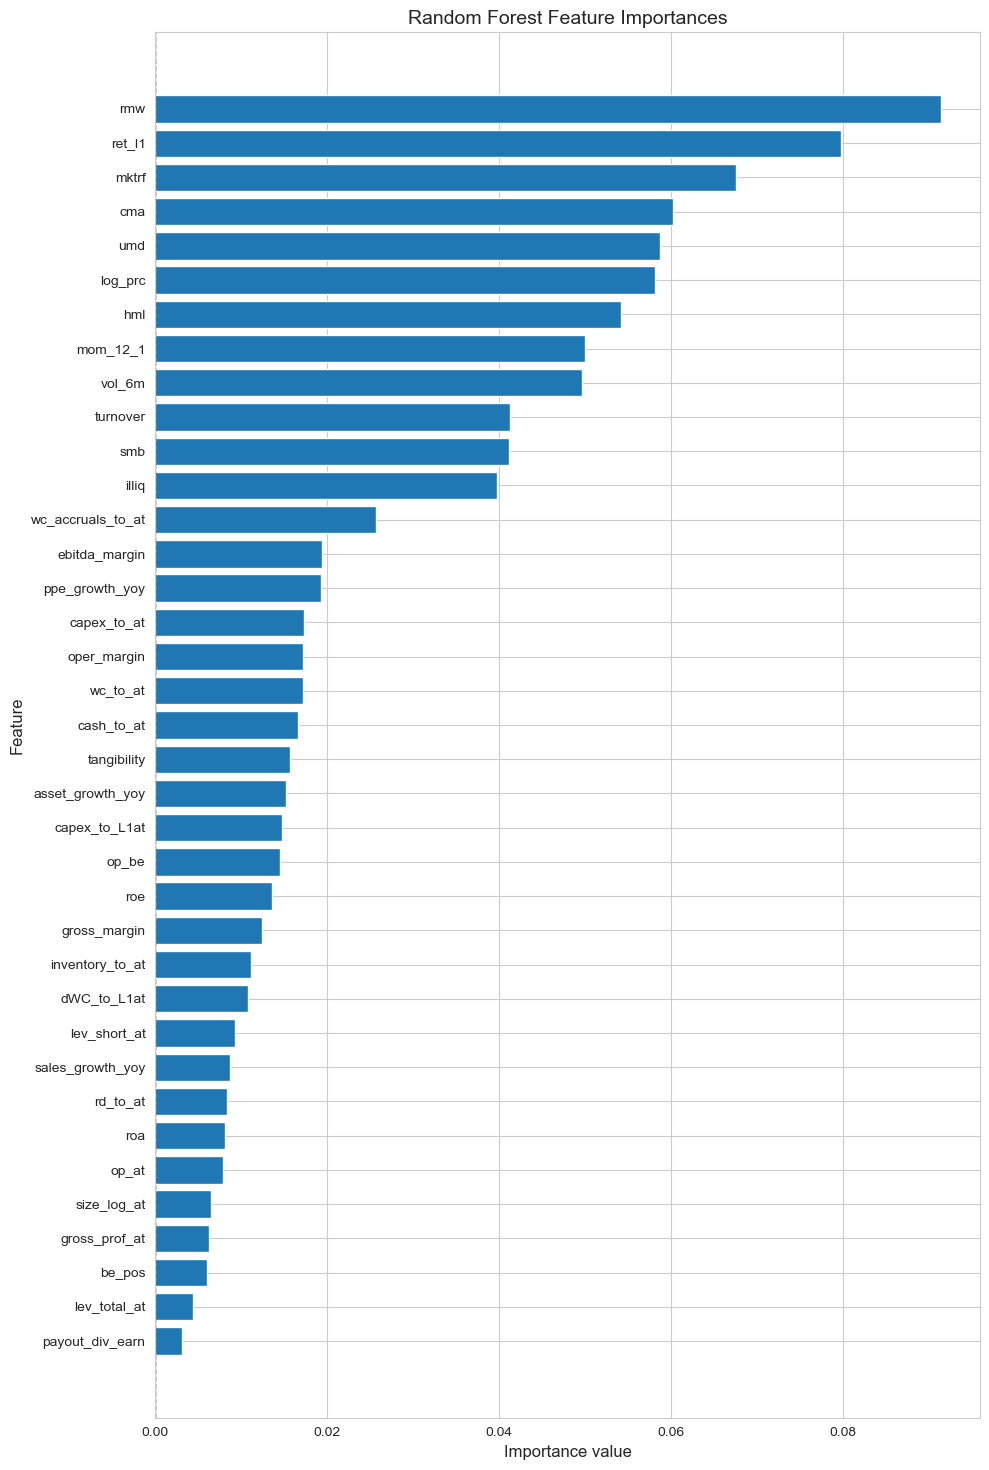

In [28]:
importance = np.asarray(rf_model.feature_importances_, dtype=float).ravel()
importance_df = (
    pd.DataFrame({"feature": X_cols, "importance": importance})
      .sort_values("importance", ascending=True)  # from low → high
      .reset_index(drop=True)
)
importance_df = importance_df[importance_df["importance"] != 0.0].reset_index(drop=True)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(importance_df))))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Gradient Boosting (Classic GBDT; Friedman, 2001)

**Idea.** Build shallow trees sequentially; each new tree fits the (pseudo-)residuals (negative gradient) of the loss from the current model.

---

### 🔹 How it works
1. Initialize $f_0$ as a constant that minimizes the loss.
2. For $m=1,\dots,M$:
   - Compute pseudo-residuals $r_i = -\partial L(y_i, f(x_i))/\partial f$ at $f_{m-1}$.
   - Fit a regression tree $h_m(x)$ to $r_i$.
   - Update $f_m(x) = f_{m-1}(x) + \eta \cdot h_m(x)$ (shrinkage $\eta$).
3. Regularize via **small learning rate**, **shallow trees**, **subsample** (stochastic GB), and **early stopping**.

---

### ✅ Strengths
- Strong tabular baseline on small/medium data.
- Few hyperparameters; **no feature scaling needed**.
- Supports **early stopping** (sklearn: `validation_fraction`, `n_iter_no_change`).

### ⚠️ Limitations
- Slower than histogram/leaf-wise boosters (XGBoost/LightGBM) on very large data.
- Requires imputation (sklearn GBDT does **not** accept NaNs).
- Sensitive to learning rate / tree depth — too large leads to overfitting.



In [29]:
gbr = GradientBoostingRegressor(
    n_estimators=1000,       
    learning_rate=0.02,
    max_depth=3,
    min_samples_leaf=8,
    subsample=0.8,          
    max_features=None,
    validation_fraction=0.2, 
    n_iter_no_change=50,
    random_state=42
)

gbr_results = evaluate_model(
    gbr, X_train_tree, y_train, X_test_tree, y_test)

all_result_df.loc[all_result_df.shape[0]] = {
    **gbr_results['metrics'],
    'Model': f"GradientBoosting(n=1000)"
}

print("=== GradientBoosting Test Results ===")
display(all_result_df)

=== GradientBoosting Test Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso
2,0.061895,0.050427,0.633803,0.093382,0.332173,1.150679,0.002112,Ridge(alpha=1e+04)
3,0.142404,0.122288,0.436620,-3.799055,-0.122692,-0.425017,0.003734,ElasticNet
4,0.061949,0.050238,0.661972,0.091803,0.344364,1.192912,0.845893,RandomForest(n=600)
5,0.062657,0.051014,0.633803,0.070912,0.300213,1.039969,0.110245,GradientBoosting(n=1000)


In [30]:
# 3) Feature importances
gbr_model = gbr_results['fitted_model']
gbr_fi = pd.DataFrame({
    "feature": feature_cols,
    "importance": gbr_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\n=== GradientBoosting Feature Importances ===")
print(gbr_fi.to_string(index=False))


=== GradientBoosting Feature Importances ===
          feature  importance
              rmw    0.147277
           ret_l1    0.120080
            mktrf    0.097922
wc_accruals_to_at    0.090568
              cma    0.069974
 asset_growth_yoy    0.063381
              umd    0.053312
           vol_6m    0.044957
         mom_12_1    0.044323
            illiq    0.043764
              hml    0.042509
              smb    0.039229
          log_prc    0.037907
         turnover    0.027757
     gross_margin    0.020576
       cash_to_at    0.012580
      dWC_to_L1at    0.009536
  inventory_to_at    0.006499
    ebitda_margin    0.006208
      size_log_at    0.005571
  payout_div_earn    0.004997
 sales_growth_yoy    0.003403
      oper_margin    0.003191
   ppe_growth_yoy    0.003130
         wc_to_at    0.001350
              roa    0.000000
     lev_short_at    0.000000
     lev_total_at    0.000000
           be_pos    0.000000
         rd_to_at    0.000000
    capex_to_L1at    0.0

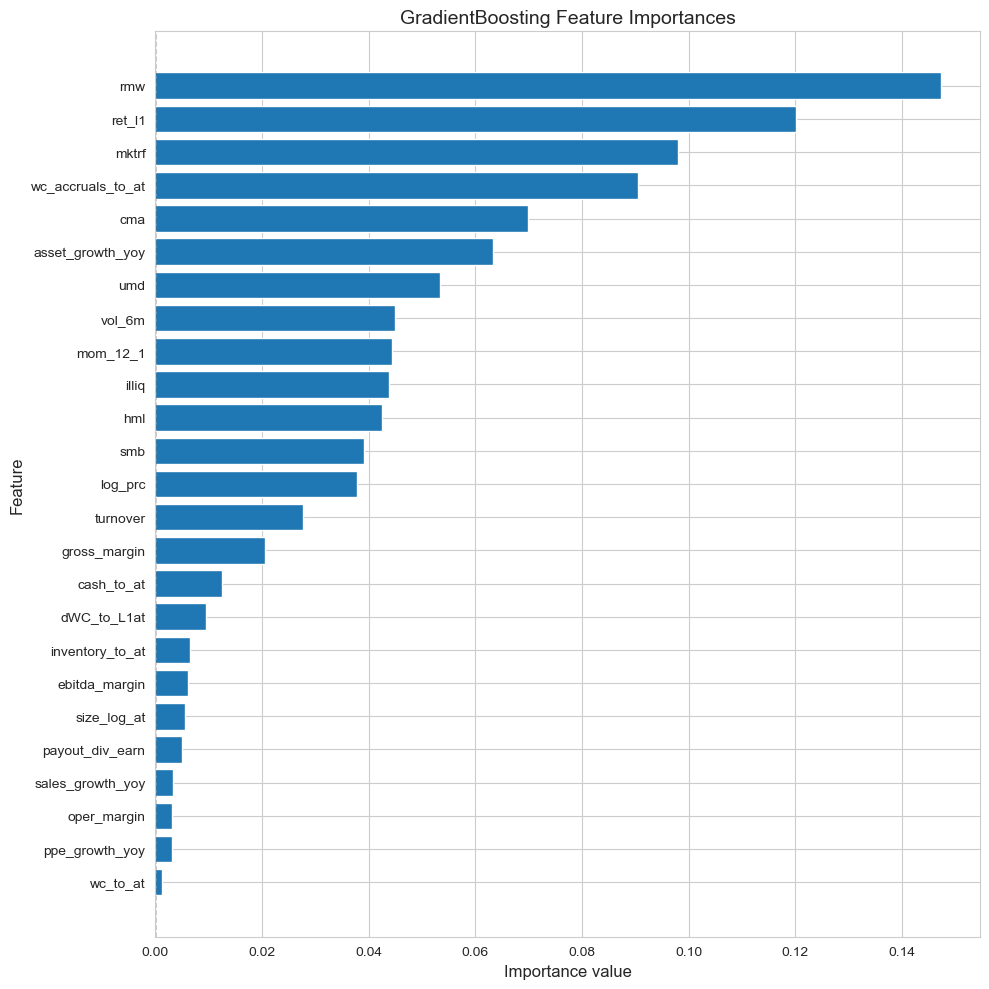

In [31]:
importance = np.asarray(gbr_model.feature_importances_, dtype=float).ravel()
importance_df = (
    pd.DataFrame({"feature": X_cols, "importance": importance})
      .sort_values("importance", ascending=True)  # from low → high
      .reset_index(drop=True)
)
importance_df = importance_df[importance_df["importance"] != 0.0].reset_index(drop=True)

# Plot all coefficients
plt.figure(figsize=(10, max(4, 0.4*len(importance_df))))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("GradientBoosting Feature Importances")
plt.xlabel("Importance value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [32]:
print("=== Summary of All Model Results ===")
display(all_result_df)

=== Summary of All Model Results ===


,rmse,mae,hit_ratio,r2_oos,sharpe_monthly,sharpe_annualized,fit_time_sec,Model
0,0.363097,0.325268,0.408451,-30.200258,-0.231775,-0.802892,0.005082,OLS
1,0.062593,0.051161,0.633803,0.072822,0.332173,1.150679,0.002159,Lasso
2,0.061895,0.050427,0.633803,0.093382,0.332173,1.150679,0.002112,Ridge(alpha=1e+04)
3,0.142404,0.122288,0.436620,-3.799055,-0.122692,-0.425017,0.003734,ElasticNet
4,0.061949,0.050238,0.661972,0.091803,0.344364,1.192912,0.845893,RandomForest(n=600)
5,0.062657,0.051014,0.633803,0.070912,0.300213,1.039969,0.110245,GradientBoosting(n=1000)


## Model Comparison

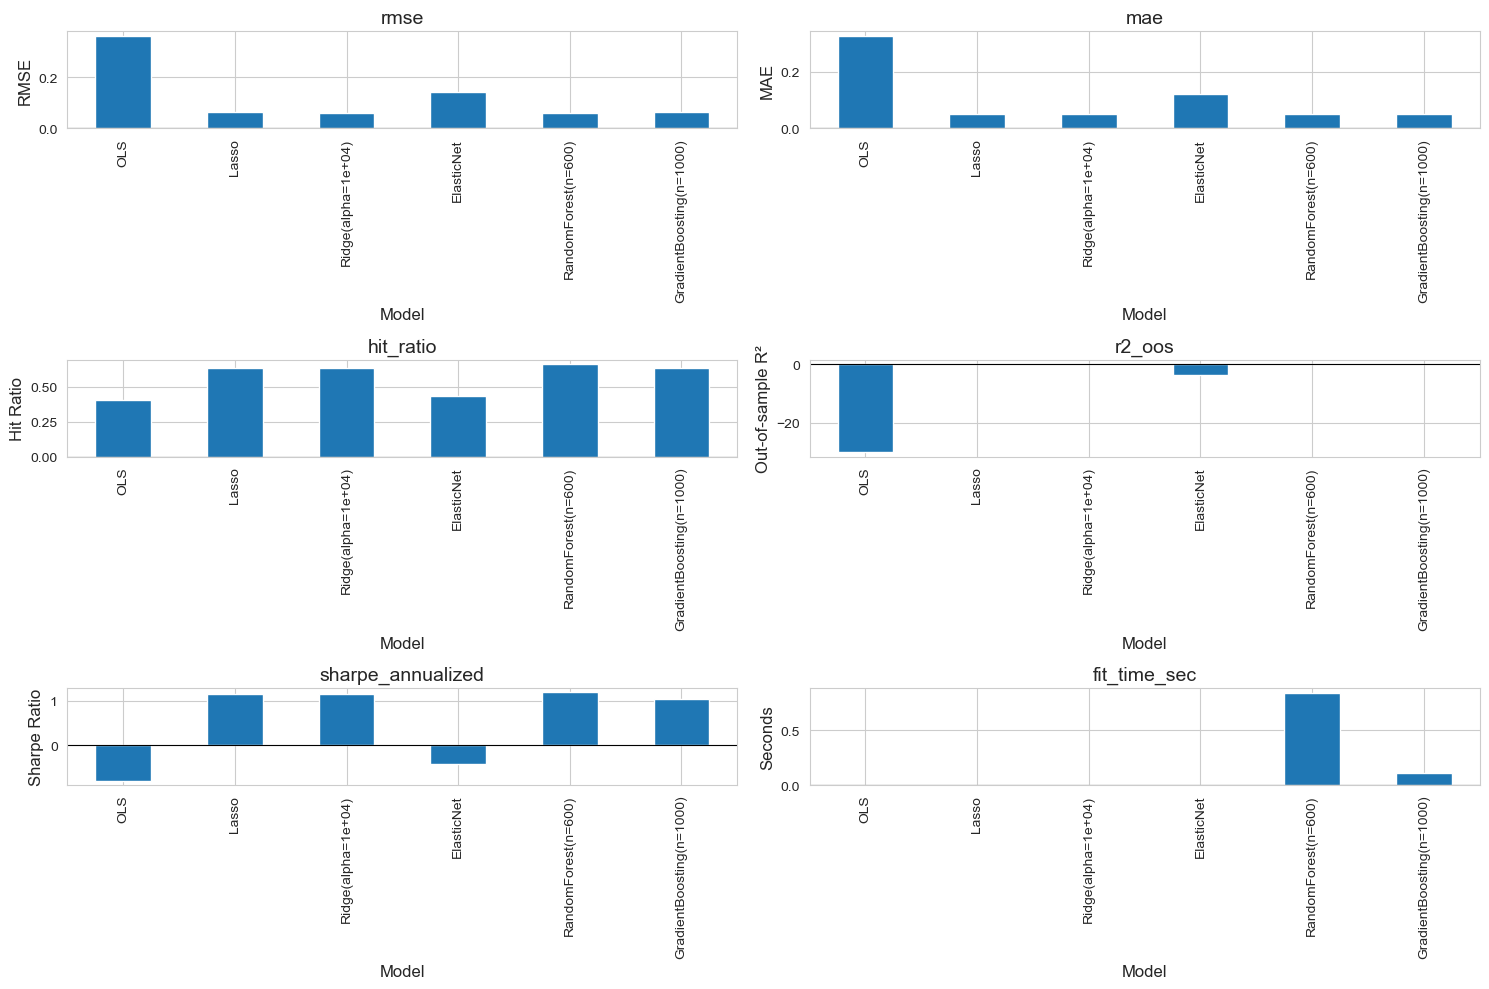

In [38]:
# Select metrics to visualize
metrics_to_plot = ["rmse", "mae", "hit_ratio", "r2_oos", "sharpe_annualized", "fit_time_sec"]

# Keep only the models and chosen metrics
plot_df = all_result_df[["Model"] + metrics_to_plot].set_index("Model")

# 3x2 subplot layout
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=False)
axes = axes.flatten()  # flatten 2D array into 1D list for easy iteration

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    plot_df[metric].plot(kind="bar", ax=ax)
    ax.set_title(metric)
    ax.set_xticklabels(plot_df.index, rotation=90)
    ax.axhline(0, color="black", linewidth=0.8)

    # y-labels
    if metric.startswith("sharpe"):
        ax.set_ylabel("Sharpe Ratio")
    elif metric == "r2_oos":
        ax.set_ylabel("Out-of-sample R²")
    elif metric == "hit_ratio":
        ax.set_ylabel("Hit Ratio")
    elif metric == "rmse":
        ax.set_ylabel("RMSE")
    elif metric == "fit_time_sec":
        ax.set_ylabel("Seconds")
    elif metric == "mae":
        ax.set_ylabel("MAE")

# Remove empty subplots if metrics < grid cells
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [35]:
# Ridge vs OLS
dm_test_from_predictions(
    y=ridge_results["y_test"],
    yhat_a=ridge_results["y_pred"],
    yhat_b=ols_results["y_pred"],
    loss="squared",   # MSPE difference, per GKX
    h=1,
    lag=0,            # robustness: also report lag=3
    alternative="two-sided"
)


{'DM': -9.890810685045844,
 'p_value': 0.0,
 'T_eff': 71,
 'mean_d': -0.1280085550302964}

In [36]:
# Random Forest vs OLS
dm_test_from_predictions(
    y=enet_results["y_test"],
    yhat_a=enet_results["y_pred"],
    yhat_b=lasso_results["y_pred"],
    loss="squared",   # MSPE difference, per GKX
    h=1,
    lag=0,            # robustness: also report lag=3
    alternative="two-sided"
)


{'DM': 7.126095296129173,
 'p_value': 1.0325074129013956e-12,
 'T_eff': 71,
 'mean_d': 0.016360972407358246}

In [37]:
# Random Forest vs OLS
dm_test_from_predictions(
    y=ridge_results["y_test"],
    yhat_a=ridge_results["y_pred"],
    yhat_b=lasso_results["y_pred"],
    loss="squared",   # MSPE difference, per GKX
    h=1,
    lag=0,            # robustness: also report lag=3
    alternative="two-sided"
)


{'DM': -1.2540965806720128,
 'p_value': 0.2098069030607448,
 'T_eff': 71,
 'mean_d': -8.68788220693108e-05}